## 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型
  #### 沒有GPU的學員可以使用Colab，可以參考問答區的文章

In [ ]:
## 使用Colab可先run這裡的code
#假如要連結自己的雲端硬碟再開啟
##from google.colab import drive
##drive.mount('/content/gdrive')
#檢查GPU
# !nvidia-smi
##安裝產生驗證碼的套件

## 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, 'JP3Y')

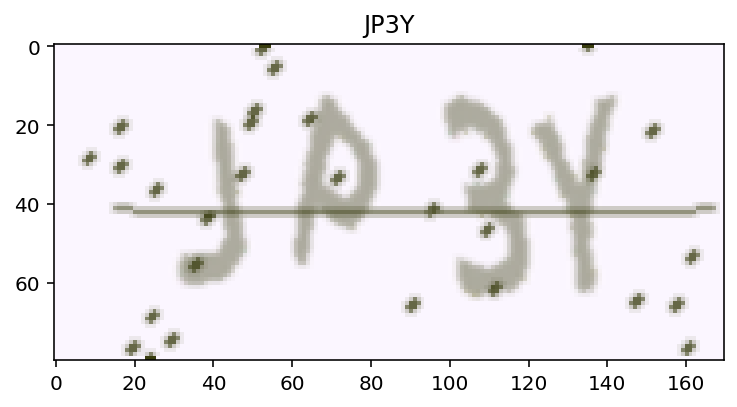

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

## 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [3]:
import numpy as np
from keras import backend as K

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Lambda

from keras.layers import Concatenate
from keras.layers import GRU

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [4]:
##CTC Loss需要四個資訊: Label, 預測, CNN OUTPUT寬度, 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [5]:
input_tensor = Input((height,width, 3))
x = input_tensor

# 參考解答模型
for i in range(4):
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)

##記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)


##包裝用來預測的model
base_model = Model(inputs=input_tensor, outputs=x)


##設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(inputs=[input_tensor, labels, input_length, label_length],
              outputs=[loss_out],
              name='CNN_for_captcha')

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

In [6]:
model.summary()

Model: "CNN_for_captcha"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 78, 168, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 166, 32)  9248        batch_normalization[0][0]        
____________________________________________________________________________________

In [7]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[10 28  0 24]]
CNN輸出寬度:  [13.]
字串長度(可浮動):  [4.]


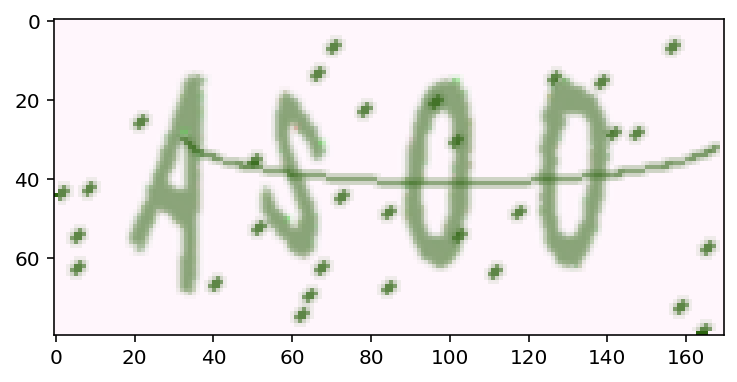

In [8]:
next_ge=gen(batch_size=1)
test_ge=next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

## 開始訓練

In [9]:
callbacks = [ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, verbose=1, min_lr=0.001),
             EarlyStopping(monitor="loss", patience=5, verbose=1)]
model.fit(gen(128), steps_per_epoch=100, epochs=200, callbacks=callbacks)

Epoch 1/200
100/100 [==============================] - 134s 1s/step - loss: 20.2254
Epoch 2/200
100/100 [==============================] - 113s 1s/step - loss: 15.3810
Epoch 3/200
100/100 [==============================] - 113s 1s/step - loss: 14.7283
Epoch 4/200
100/100 [==============================] - 112s 1s/step - loss: 13.4152
Epoch 5/200
100/100 [==============================] - 111s 1s/step - loss: 11.5709
Epoch 6/200
100/100 [==============================] - 114s 1s/step - loss: 9.8179
Epoch 7/200
100/100 [==============================] - 112s 1s/step - loss: 8.4990
Epoch 8/200
100/100 [==============================] - 111s 1s/step - loss: 7.4456
Epoch 9/200
100/100 [==============================] - 110s 1s/step - loss: 6.6327
Epoch 10/200
100/100 [==============================] - 109s 1s/step - loss: 5.9535
Epoch 11/200
100/100 [==============================] - 121s 1s/step - loss: 5.4194
Epoch 12/200
100/100 [==============================] - 112s 1s/step - loss: 5.0

## 預測

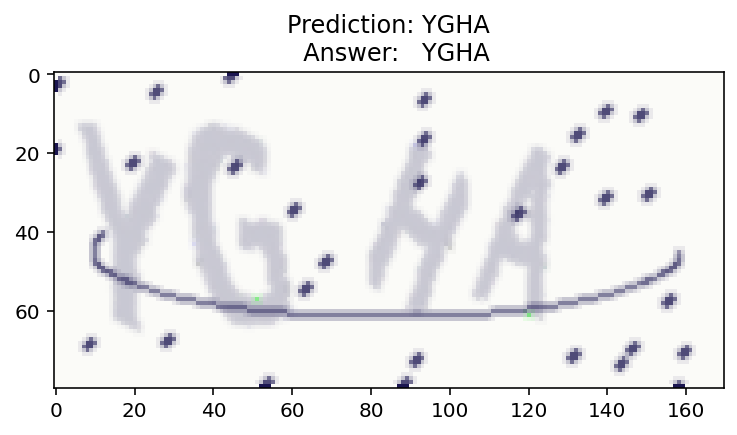

In [10]:
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)

##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0] if x != -1])
y_true = ''.join([characters[x] for x in y_test[0]])

# 圖片輸出
plt.imshow(X_test[0])
plt.title(f'Prediction: {str(out)}\n  Answer:   {str(y_true)}')

argmax = np.argmax(y_pred, axis=2)[0]
plt.show()

## 自己寫 decode CTC

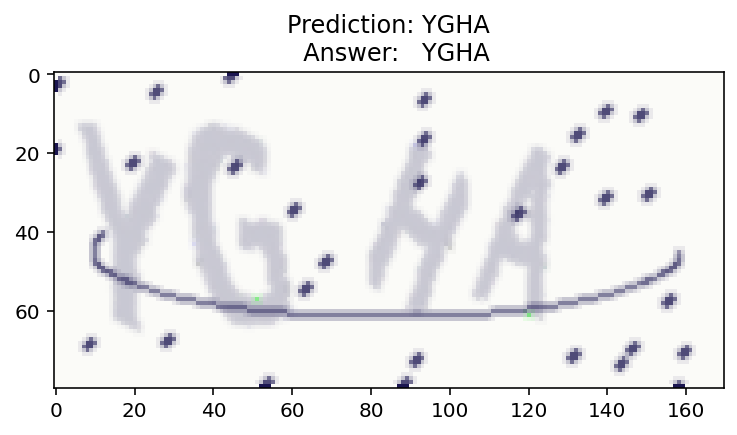

In [11]:
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word, n = '', ''
for single_result in y_pred[0].argmax(1):
    if single_result != 36:
        if n != single_result:
            word += characters[single_result]
    n = single_result 

# 圖片輸出
plt.imshow(X_test[0])
plt.title(f'Prediction: {str(out)}\n  Answer:   {str(y_true)}')

argmax = np.argmax(y_pred, axis=2)[0]
plt.show()

## 額外參考：加入RNN的神經網路

In [12]:
K.clear_session() 
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)


conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)
x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             kernel_initializer='he_normal', name='gru1_b')(x)
gru1_merged = Concatenate()([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
x = Concatenate()([gru_2, gru_2b])

x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)

base_model = Model(inputs=input_tensor, outputs=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length,label_length],
              outputs=[loss_out],
              name='RCNN_for_captcha')
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

In [13]:
model.summary()

Model: "RCNN_for_captcha"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 78, 168, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 166, 32)  9248        batch_normalization[0][0]        
___________________________________________________________________________________

In [14]:
callbacks = [ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, verbose=1, min_lr=0.001),
             EarlyStopping(monitor="loss", patience=5, verbose=1)]
model.fit(gen(128), steps_per_epoch=100, epochs=200, callbacks=callbacks)

Epoch 1/200
100/100 [==============================] - 130s 1s/step - loss: 18.4257
Epoch 2/200
100/100 [==============================] - 111s 1s/step - loss: 14.9862
Epoch 3/200
100/100 [==============================] - 114s 1s/step - loss: 9.5142
Epoch 4/200
100/100 [==============================] - 112s 1s/step - loss: 3.8160
Epoch 5/200
100/100 [==============================] - 112s 1s/step - loss: 2.4639
Epoch 6/200
100/100 [==============================] - 112s 1s/step - loss: 1.9374
Epoch 7/200
100/100 [==============================] - 111s 1s/step - loss: 1.5815
Epoch 8/200
100/100 [==============================] - 112s 1s/step - loss: 1.4055
Epoch 9/200
100/100 [==============================] - 113s 1s/step - loss: 1.1876
Epoch 10/200
100/100 [==============================] - 113s 1s/step - loss: 1.0482
Epoch 11/200
100/100 [==============================] - 112s 1s/step - loss: 0.9682
Epoch 12/200
100/100 [==============================] - 116s 1s/step - loss: 0.8768

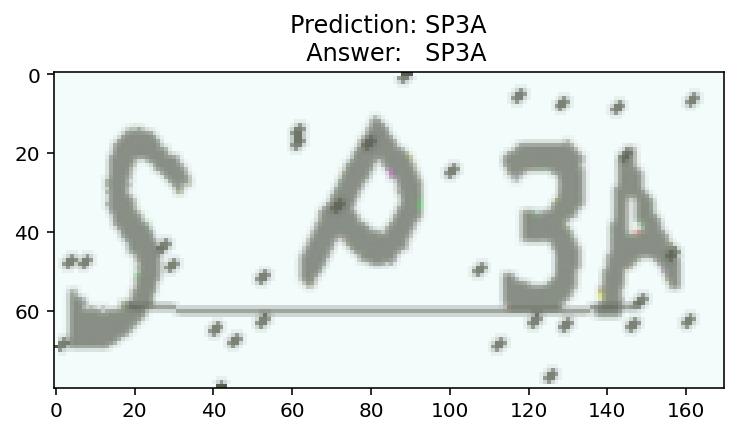

In [15]:
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)

##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0] if x != -1])
y_true = ''.join([characters[x] for x in y_test[0]])

# 圖片輸出
plt.imshow(X_test[0])
plt.title(f'Prediction: {str(out)}\n  Answer:   {str(y_true)}')

argmax = np.argmax(y_pred, axis=2)[0]
plt.show()